In [25]:
import ROOT, os, sys, glob
import numpy as np
import math
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed
from array import array

ROOT.EnableImplicitMT(4); 

In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.1.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M3p5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M40_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M4_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1

In [3]:
rdf = ROOT.RDataFrame("Events","/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root")

In [4]:
rdf.Describe()

Dataframe from TChain Events in file /eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root

Property                Value
--------                -----
Columns in total           34
Columns from defines        0
Event loops run             0
Processing slots            4

Column          Type                            Origin
------          ----                            ------
GenMu_charge    ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_d0        ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_eta       ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_isFromTau ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_isPrompt  ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_mass      ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_phi       ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_pt        ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_vz        ROOT::VecOps::RVec<Float_t>     Dataset
TkMu_GenMuFlav  ROOT::VecOps::RVec<UChar_t>     Dataset
TkMu_GenMu

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


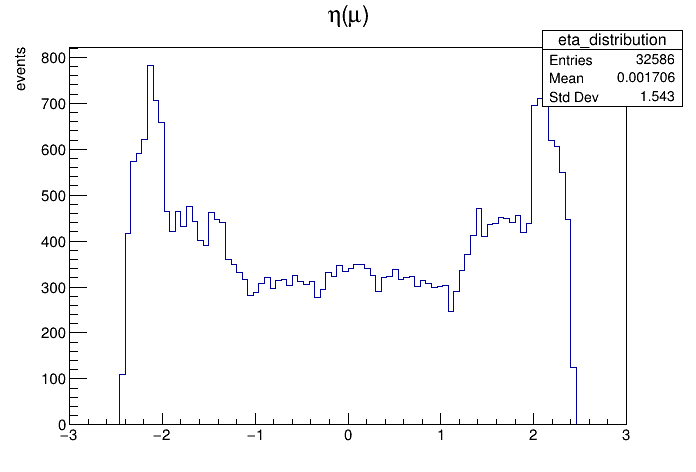

In [5]:
hEta_plot = rdf.Histo1D(("eta_distribution","#eta(#mu);;events",100,-3,3),"TkMu_eta")
c = ROOT.TCanvas()
c.cd()
hEta_plot.Draw()
c.Draw()

In [6]:
def makeDimuonPairs(name, rdf):
    ## define 4-vectors in cartesian coordinates, for easier 
    rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
    ## make indices of all the pairs
    rdf = rdf.Define(f"{name}DiMu_indices", f"""
        ROOT::VecOps::RVec<std::pair<int,int>> ret; 
        for (int i = 0, n = n{name}Mu; i < n; ++i) 
            for (int i2 = i+1; i2 < n; ++i2) 
                ret.emplace_back(i,i2);
        return ret;""")
    
    #Let us impose a selection criteria here
    
    
    ## Make the number of dimuons, for convenience later
    rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
    ## compute the mass, charge
    rdf = rdf.Define(f"{name}DiMu_mass", f"""
        ROOT::RVecF ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_charge", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
        return ret;""")
    
    
    
    rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
        ROOT::RVecI ret;
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_eta", f"""
        ROOT::RVecF ret;
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
        return ret;""")
    
    return rdf;


In [7]:
def makeTk_DiMuonPairs(rdf):
    
    #this is to defne DiMuon pairs for different properties
     rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : TkDiMu_indices) 
            ret.emplace_back(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second]));
        return ret;""")
        
     rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : TkDiMu_indices) 
            ret.emplace_back(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second]));
        return ret;""")
        
     rdf = rdf.Define(f"TkDiMu_hwQual", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : TkDiMu_indices) 
            ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
        return ret;""")
    
     return rdf;

Processed 8957 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


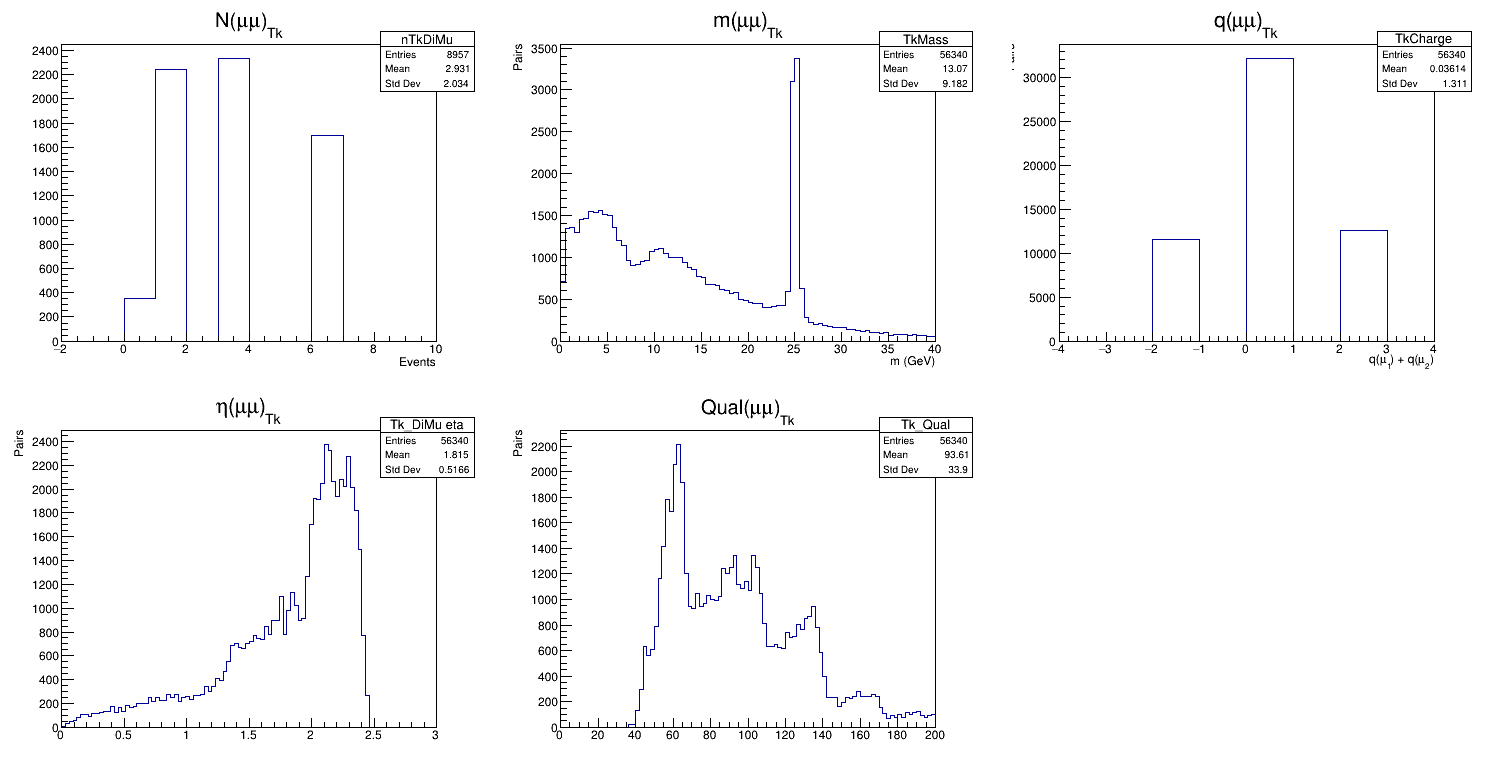

In [8]:
rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf)
rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNTkPairs = rdf_Tkdimu.Histo1D(("nTkDiMu","N(#mu#mu)_{Tk};Events",12,-2,10), "nTkDiMu")
hTkPairMass = rdf_Tkdimu.Histo1D(("TkMass","m(#mu#mu)_{Tk};m (GeV);Pairs",80,0,40), "TkDiMu_mass")
hTkPairCharge = rdf_Tkdimu.Histo1D(("TkCharge","q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_charge")
#hTkPair_hwIsoSum = rdf_Tkdimu.Histo1D(("Tk_IsoSum","Iso Sum(#mu#mu)_{Tk};;Pairs",100,-0.5,0.5),"TkDiMu_hwIsoSum")
#hTkPair_hwIsoSumAp = rdf_Tkdimu.Histo1D(("Tk_IsoSumAp","Iso Sum Ap(#mu#mu)_{Tk};;Pairs",100,-0.5,0.5),"TkDiMu_hwIsoSumAp")
hTkPair_hwQual = rdf_Tkdimu.Histo1D(("Tk_Qual","Qual(#mu#mu)_{Tk};;Pairs",100,0,200),"TkDiMu_hwQual")
hTkPair_eta = rdf_Tkdimu.Histo1D(("Tk_DiMu eta","#eta(#mu#mu)_{Tk};;Pairs",100,0,3),"TkDiMu_eta")

entries_TkDiMu_full = rdf_Tkdimu.Count().GetValue()
print(f"Processed {entries_TkDiMu_full} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNTkPairs, hTkPairMass, hTkPairCharge, hTkPair_eta, hTkPair_hwQual]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

Processed 8957 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


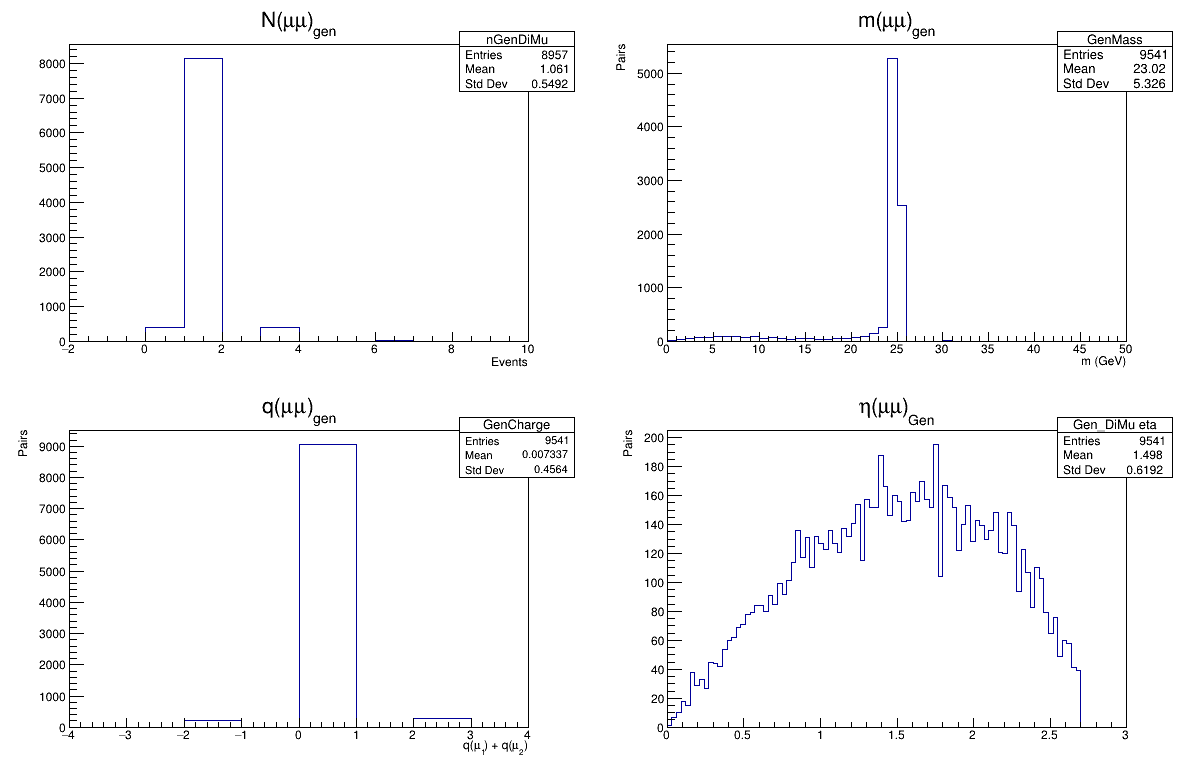

In [9]:
rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)

hNGenPairs = rdf_genDiMu.Histo1D(("nGenDiMu","N(#mu#mu)_{gen};Events",12,-2,10), "nGenDiMu")
hGenPairMass = rdf_genDiMu.Histo1D(("GenMass","m(#mu#mu)_{gen};m (GeV);Pairs",50,0,50), "GenDiMu_mass")
hGenPairCharge = rdf_genDiMu.Histo1D(("GenCharge","q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "GenDiMu_charge")
hGenPairEta = rdf_genDiMu.Histo1D(("Gen_DiMu eta","#eta(#mu#mu)_{Gen};;Pairs",100,0,3),"GenDiMu_eta")

entries_genDiMu_full = rdf_genDiMu.Count().GetValue()
print(f"Processed {entries_genDiMu_full} entries.")


## And plot it
c1 = ROOT.TCanvas("c1","c1", 1200, 800)
c1.Divide(2,2)
for i, h in enumerate([hNGenPairs,hGenPairMass,hGenPairCharge,hGenPairEta]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [10]:
def dimuonextra(name,rdf):
    #separation along the beamline
    rdf=rdf.Define(f"{name}DiMu_dz",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
    return ret;""")
    #min pT of thw two
    rdf = rdf.Define(f"{name}Mu_minPT",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
    return ret;""") #
    
    return rdf;

Processed 8957 entries.


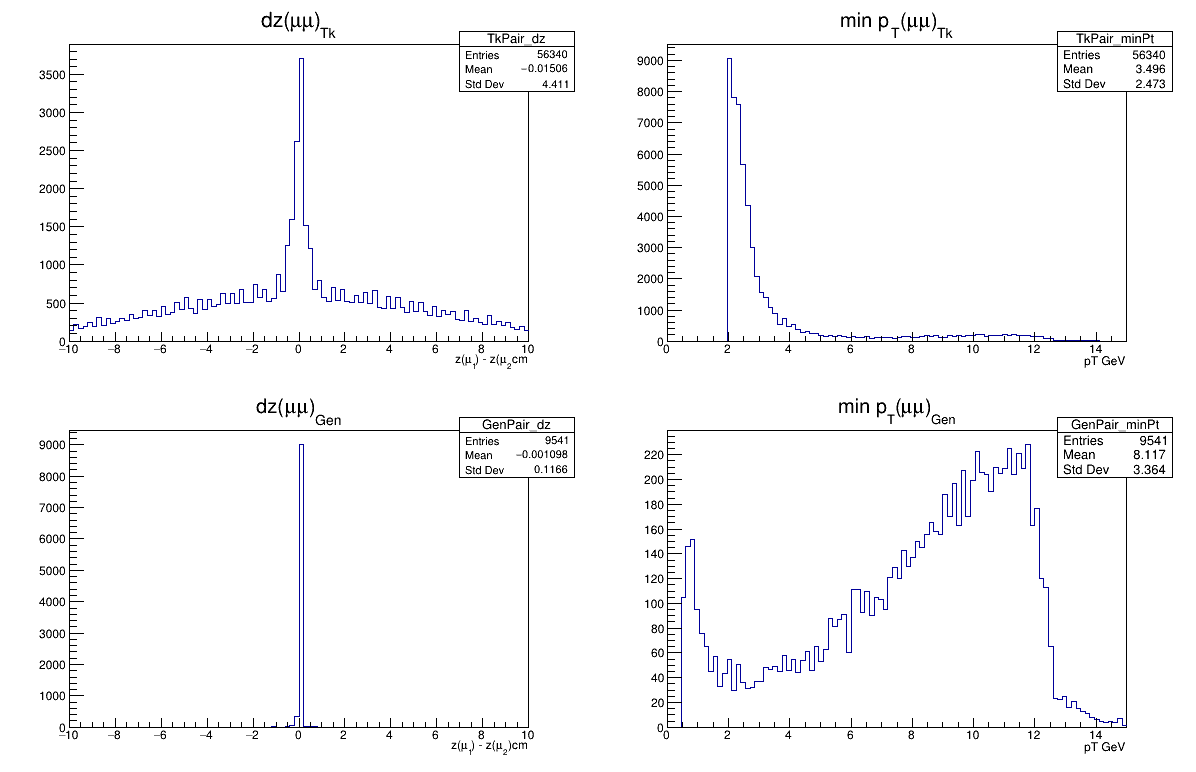

In [11]:
rdf_tkextra = dimuonextra("Tk", dimuonextra("Gen",rdf_genDiMu)) #this is done to essentially include all the newly created Rdfs in the final rdf

hTkPair_Dz = rdf_tkextra.Histo1D(("TkPair_dz","dz(#mu#mu)_{Tk};z(#mu_{1}) - z(#mu_{2}cm",100,-10,10),"TkDiMu_dz")
hTkPair_minPt = rdf_tkextra.Histo1D(("TkPair_minPt","min p_{T}(#mu#mu)_{Tk};pT GeV",100,0,15),"TkMu_minPT")
hGenPair_Dz = rdf_tkextra.Histo1D(("GenPair_dz","dz(#mu#mu)_{Gen};z(#mu_{1}) - z(#mu_{2})cm",100,-10,10),"GenDiMu_dz")
hGenPair_minPt = rdf_tkextra.Histo1D(("GenPair_minPt","min p_{T}(#mu#mu)_{Gen};pT GeV",100,0,15),"GenMu_minPT")


entries_TkDiMuExtra_full = rdf_Tkdimu.Count().GetValue()
print(f"Processed {entries_TkDiMuExtra_full} entries.")

## And plot it
c2 = ROOT.TCanvas("c2","c2", 1200, 800)
c2.Divide(2,2)
for i, h in enumerate([hTkPair_Dz, hTkPair_minPt, hGenPair_Dz, hGenPair_minPt]):
    c2.cd(i+1)
    h.Draw()
c2.Draw()

In [12]:
def indexSelect(rdf):
    rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
    rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
    rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
    rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
    rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
    rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
    rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
    rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
    rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
    rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
    rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
    rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
    return rdf;

rdf_idxSel = indexSelect(rdf_tkextra)

Processed 7165 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


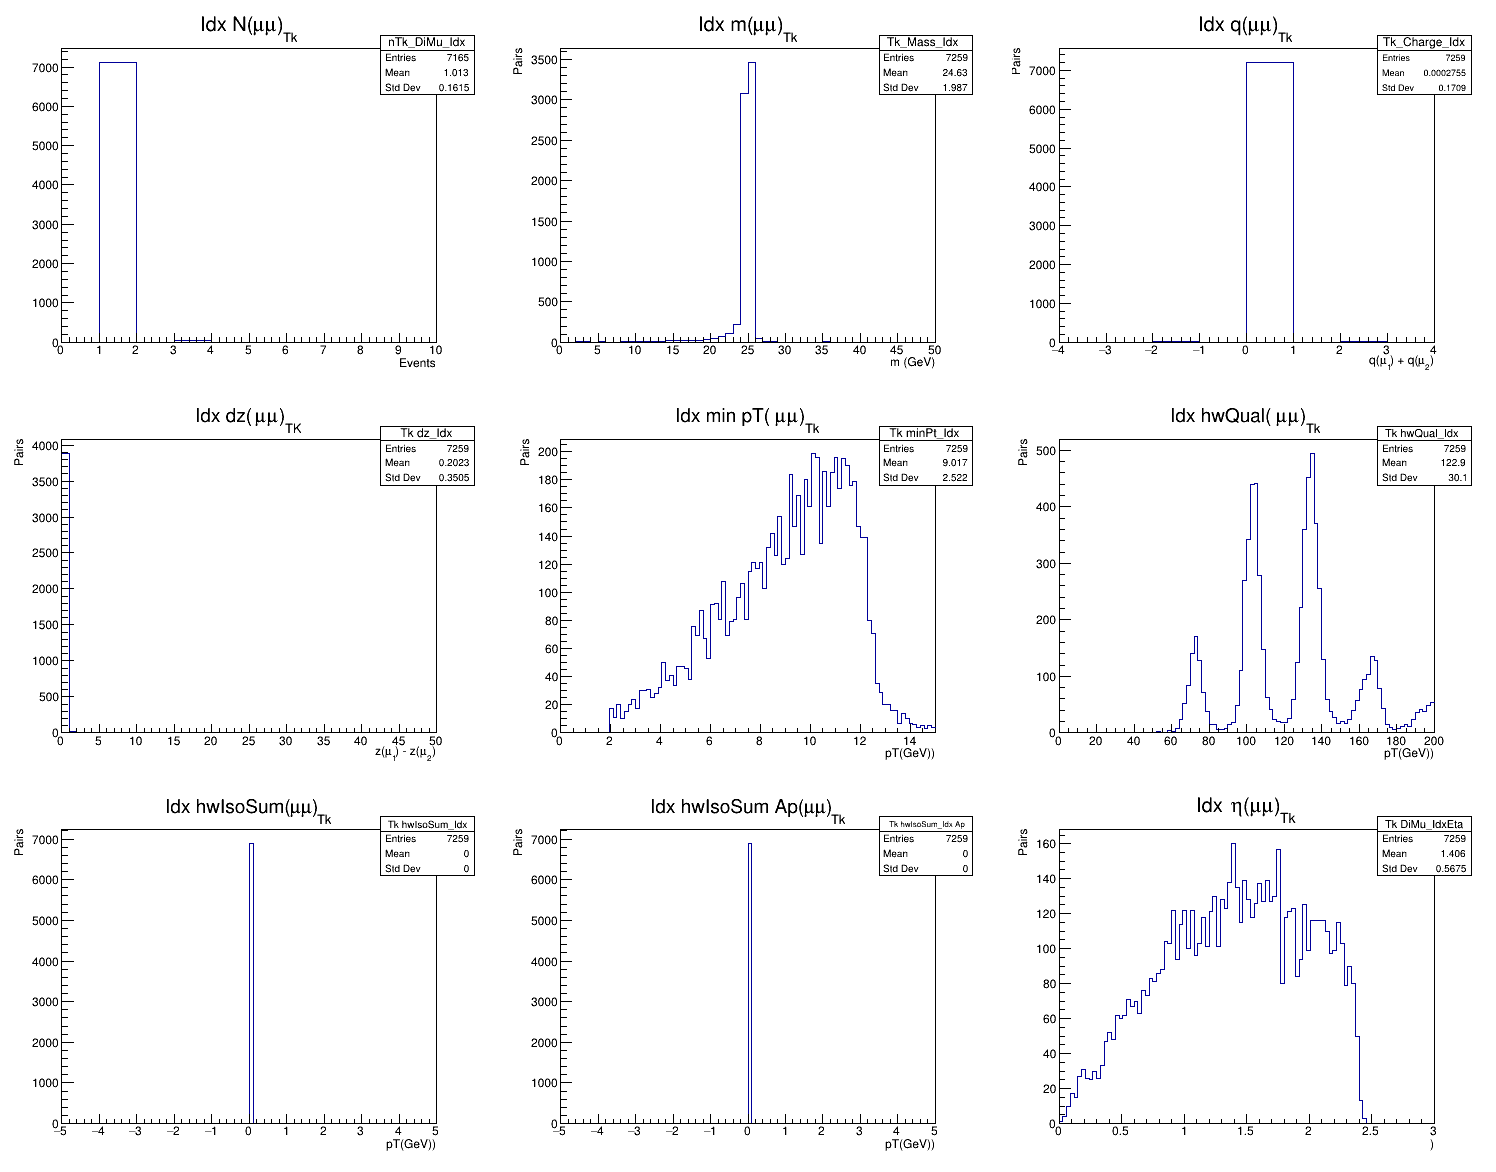

In [13]:
hNIdxTkPairs = rdf_idxSel.Histo1D(("nTk_DiMu_Idx","Idx N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_Idx")
hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")
hIdxTkPairCharge = rdf_idxSel.Histo1D(("Tk_Charge_Idx","Idx q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_IdxCharge")
hIdxTkPairDz = rdf_idxSel.Histo1D((" Tk dz_Idx","Idx dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",50,0,50), "TkDiMu_Idxdz")
hIdxTkPairMinPT = rdf_idxSel.Histo1D((" Tk minPt_Idx","Idx min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,15), "TkDiMu_IdxMinPt")
hIdxTkPair_hwQual = rdf_idxSel.Histo1D((" Tk hwQual_Idx","Idx hwQual(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,200), "TkDiMu_IdxhwQual")
hIdxTkPair_hwIsoSum = rdf_idxSel.Histo1D((" Tk hwIsoSum_Idx","Idx hwIsoSum(#mu#mu)_{Tk};pT(GeV));Pairs",100,-5,5), "TkDiMu_IdxhwIsoSum")
hIdxTkPair_hwIsoSumAp = rdf_idxSel.Histo1D((" Tk hwIsoSum_Idx Ap","Idx hwIsoSum Ap(#mu#mu)_{Tk};pT(GeV));Pairs",100,-5,5), "TkDiMu_IdxhwIsoSumAp")
hIdxTkPair_Eta = rdf_idxSel.Histo1D(("Tk DiMu_IdxEta","Idx #eta(#mu#mu)_{Tk};);Pairs",100,0,3), "TkDiMu_IdxEta")

entries_TkDi_Idx = rdf_idxSel.Count().GetValue()
print(f"Processed {entries_TkDi_Idx} entries.")


c1 = ROOT.TCanvas("c1","c1", 1500, 1200)
c1.Divide(3,3)
for i, h in enumerate([hNIdxTkPairs, hIdxTkPairMass, hIdxTkPairCharge, hIdxTkPairDz, hIdxTkPairMinPT, hIdxTkPair_hwQual, hIdxTkPair_hwIsoSum, hIdxTkPair_hwIsoSumAp, hIdxTkPair_Eta]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [14]:
def select_ind(name, rdf):
    
    #Let us impose a selection criteria here
    #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
    rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.)&&({name}DiMu_eta <= 2)")                    
    rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
    rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
    rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
    rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")
    
    #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
    return rdf;
rdf_gendisel = select_ind("Gen",rdf_idxSel)

Processed 5866 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


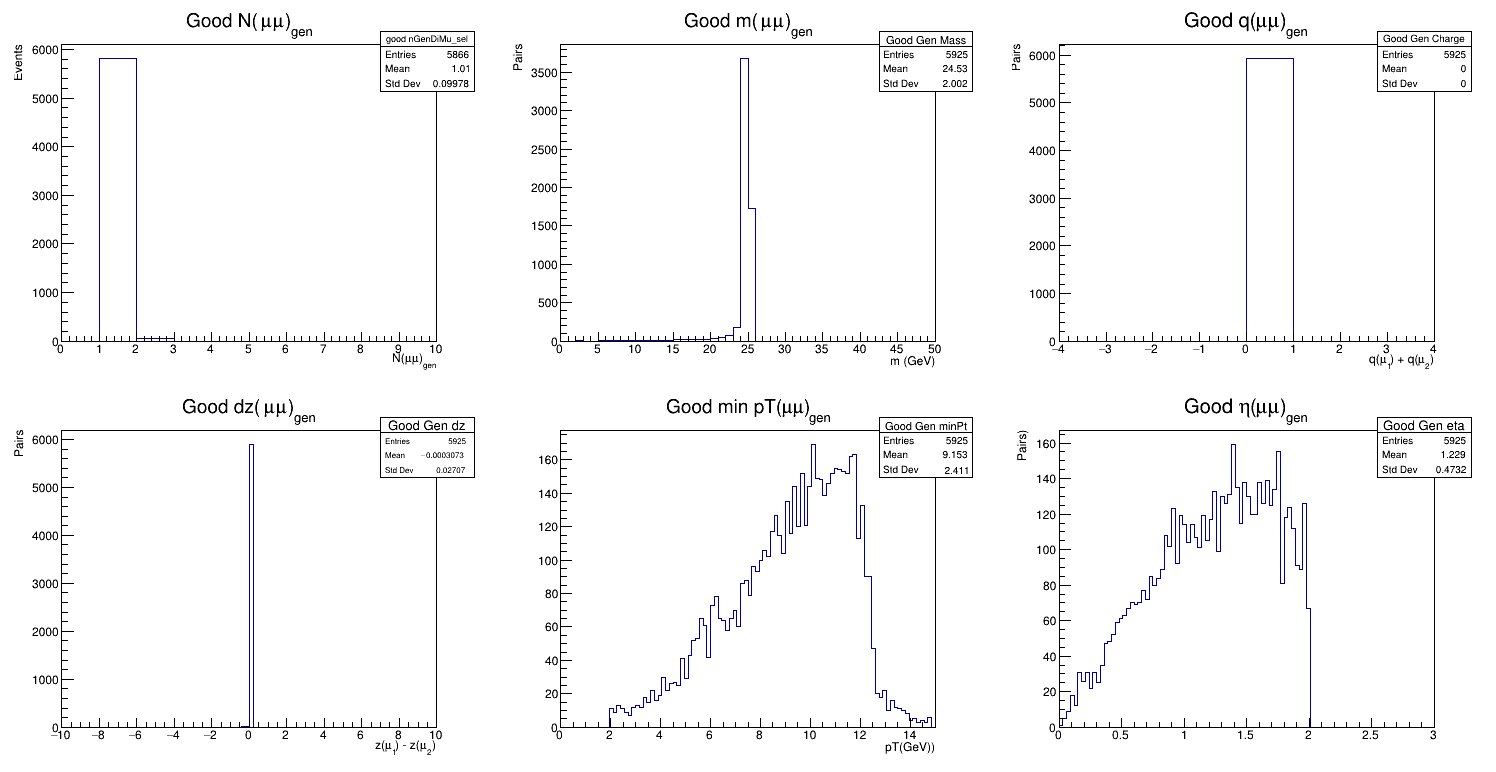

In [15]:
rdf_selFeat = rdf_gendisel
hNGoodGenPairs = rdf_selFeat.Histo1D(("good nGenDiMu_sel","Good N(#mu#mu)_{gen};N(#mu#mu)_{gen};Events",10,0,10), "nGenDiMu_sel")
hGoodGenPairMass = rdf_selFeat.Histo1D(("Good Gen Mass","Good m(#mu#mu)_{gen};m (GeV);Pairs",50,0,50), "GenDiMu_selMass")
hGoodGenPairCharge = rdf_selFeat.Histo1D(("Good Gen Charge","Good q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "GenDiMu_selCharge")
hGoodGenPairDz = rdf_selFeat.Histo1D(("Good Gen dz","Good dz(#mu#mu)_{gen};z(#mu_{1}) - z(#mu_{2});Pairs",100,-10,10), "GenDiMu_seldz")
hGoodGenPairMinPT = rdf_selFeat.Histo1D(("Good Gen minPt","Good min pT(#mu#mu)_{gen};pT(GeV))",100,0,15), "GenDiMu_selMinPt")
hGoodGenPairEta = rdf_selFeat.Histo1D(("Good Gen eta","Good #eta(#mu#mu)_{gen};;Pairs)",100,0,3), "GenDiMu_selEta")
#rdf_selFeat.Describe()
entries_genDi_cut = rdf_selFeat.Count().GetValue()
print(f"Processed {entries_genDi_cut} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNGoodGenPairs, hGoodGenPairMass, hGoodGenPairCharge, hGoodGenPairDz, hGoodGenPairMinPT, hGoodGenPairEta]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [16]:
rdf_Tk_selFeat = select_ind("Tk", rdf_selFeat)

In [17]:
def select_idx_tk(rdf):
    
    #Let us impose a selection criteria here
    #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
    rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 2.) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <=2) ")                    
    rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
    rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
    rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
    rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")
    rdf = rdf.Define(f"TkDiMu_IdxselEta",f"TkDiMu_IdxEta[TkDiMu_Idx_good]")

    return rdf;
rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)

Processed 5305 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


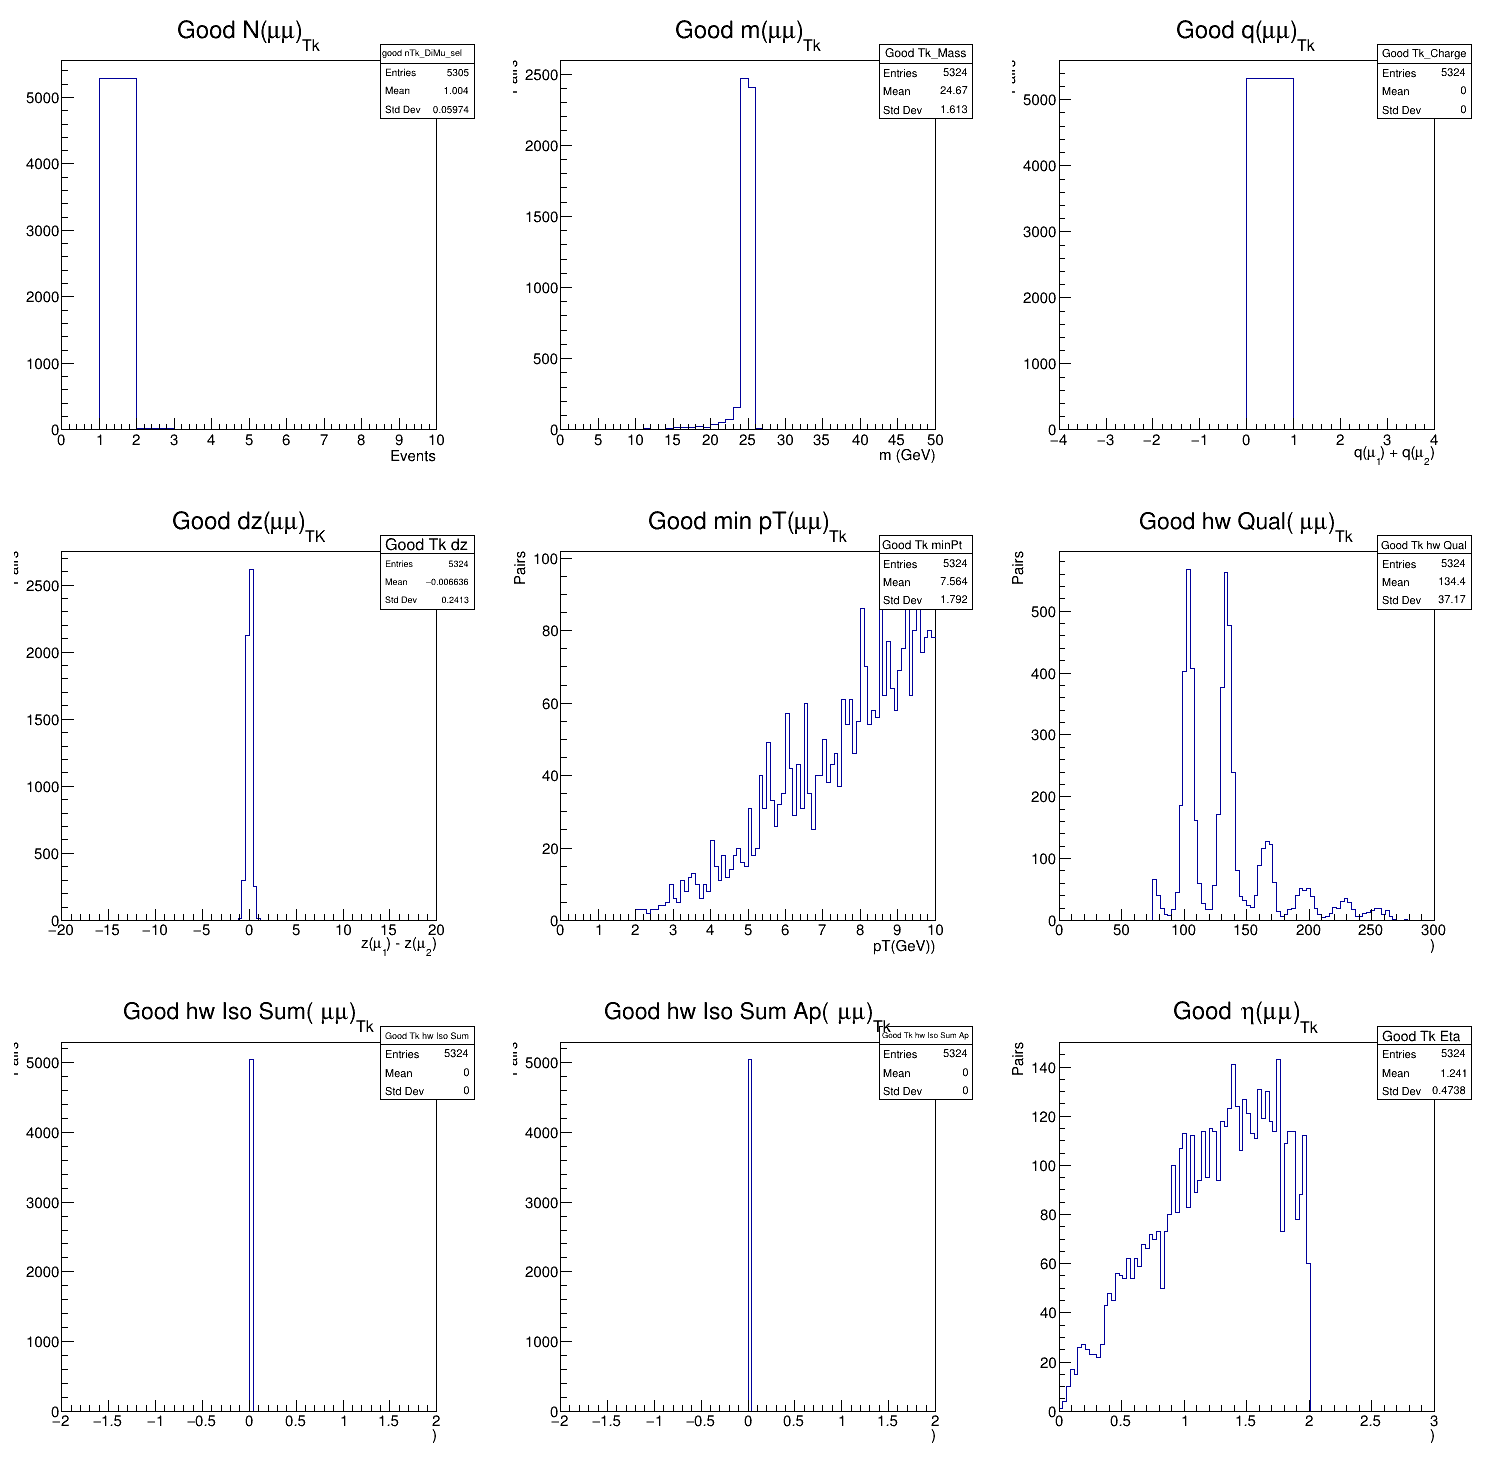

In [28]:
hNGoodIdxTkPairs = rdf_Tk_IdxselFeat.Histo1D(("good nTk_DiMu_sel","Good N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_IdxSel")
hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
hGoodIdxTkPairCharge = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Charge","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_IdxselCharge")
hGoodIdxTkPairDz = rdf_Tk_IdxselFeat.Histo1D(("Good Tk dz","Good dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",100,-20,20), "TkDiMu_Idxseldz")
hGoodIdxTkPairMinPT = rdf_Tk_IdxselFeat.Histo1D(("Good Tk minPt","Good min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_IdxselMinPt")
hGoodIdxTkPairhwQual = rdf_Tk_IdxselFeat.Histo1D(("Good Tk hw Qual","Good hw Qual(#mu#mu)_{Tk};);Pairs",100,0,300), "TkDiMu_IdxselhwQual")
hGoodIdxTkPairhwIsoSum = rdf_Tk_IdxselFeat.Histo1D(("Good Tk hw Iso Sum","Good hw Iso Sum(#mu#mu)_{Tk};);Pairs",100,-2,2), "TkDiMu_IdxselhwIsoSum")
hGoodIdxTkPairhwIsoSumAp = rdf_Tk_IdxselFeat.Histo1D(("Good Tk hw Iso Sum Ap","Good hw Iso Sum Ap(#mu#mu)_{Tk};);Pairs",100,-2,2), "TkDiMu_IdxselhwIsoSumAp")
hGoodIdxTkPairEta = rdf_Tk_IdxselFeat.Histo1D(("Good Tk Eta","Good #eta(#mu#mu)_{Tk};);Pairs",100,0,3), "TkDiMu_IdxselEta")


entries = rdf_Tk_IdxselFeat.Count().GetValue()

#rdf_selFeat.Describe()
entries_TkDi_Idx_cut = rdf_Tk_IdxselFeat.Count().GetValue()
print(f"Processed {entries_TkDi_Idx_cut} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 1500)
c1.Divide(3,3)
for i, h in enumerate([hNGoodIdxTkPairs, hGoodIdxTkPairMass, hGoodIdxTkPairCharge, hGoodIdxTkPairDz, hGoodIdxTkPairMinPT, hGoodIdxTkPairhwQual, hGoodIdxTkPairhwIsoSum, hGoodIdxTkPairhwIsoSumAp, hGoodIdxTkPairEta]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [19]:
h1 = hGoodIdxTkPairMass.GetPtr()
h1.SetLineColor(kBlue+1)
h1.SetLineWidth(2)
h1.SetMaximum(4000)
h2 = hIdxTkPairMass.GetPtr()
h2.SetLineColor(kRed)
h2.SetLineWidth(2)
h2.SetMaximum(4000)

In [20]:
def createRatio(h1, h2):
    h3 = h1.Clone("h3")
    h3.SetLineColor(kBlack)
    h3.SetMarkerStyle(21)
    h3.SetTitle("")
    h3.SetMinimum(0)
    h3.SetMaximum(1.2)
    # Set up plot for markers and errors
    h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
    h3.SetStats(0)
    h3.Divide(h2)
 
#     # Adjust y-axis settings
    y = h3.GetYaxis()
    y.SetTitle("ratio h1/h2 ")
    y.SetNdivisions(505)
    y.SetTitleSize(20)
    y.SetTitleFont(43)
    y.SetTitleOffset(1.55)
    y.SetLabelFont(43)
    y.SetLabelSize(15)
 
#     # Adjust x-axis settings
    x = h3.GetXaxis()
    x.SetTitleSize(20)
    x.SetTitleFont(43)
    x.SetTitleOffset(4.0)
    x.SetLabelFont(43)
    x.SetLabelSize(15)
 
    return h3;
 

In [21]:
def createCanvasPads():
    c = ROOT.TCanvas("c", "canvas", 800, 800)
    # Upper histogram plot is pad1
    pad1 =ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0)  # joins upper and lower plot
    pad1.SetGridx()
    pad1.Draw()
    # Lower ratio plot is pad2
    c.cd()  # returns to main canvas before defining pad2
    pad2 =ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)  # joins upper and lower plot
    pad2.SetBottomMargin(0.2)
    pad2.SetGridx()
    
    pad2.Draw()
 
    return c, pad1, pad2;

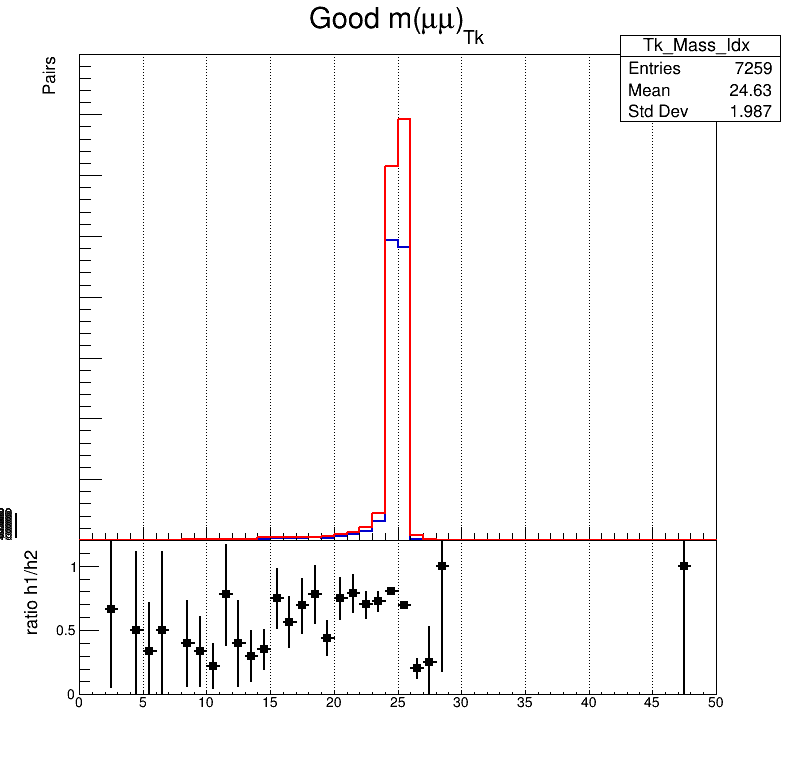

In [22]:
h3 = createRatio(h1, h2)
c, pad1, pad2 = createCanvasPads()
pad1.cd()
h1.Draw()
h2.Draw("same")
# to avoid clipping the bottom zero, redraw a small axis
h1.GetYaxis().SetLabelSize(0.0)
axis =ROOT.TGaxis(-5, 20, -5, 220, 20, 220, 510, "")
axis.SetLabelFont(43)
axis.SetLabelSize(15)
axis.Draw()
pad2.cd()
h3.Draw("ep")
c.Draw()

In [23]:
def dY_Number(h, cross_sec, L, entries):
    h_final = h.Clone()
    h_final.Scale((cross_sec*L)/entries)
    return h_final;

In [ ]:
h5 = dY_Number(h1, 2*(10**(1)), 400,entries_TkDi_Idx )
y=h5.GetYaxis()
y.SetTitle("signal number")
y.SetNdivisions(505)
y.SetTitleSize(20)
y.SetTitleFont(43)
y.SetTitleOffset(1.55)
y.SetLabelFont(43)
y.SetLabelSize(15)
c = ROOT.TCanvas()
c.cd()
h5.Draw("hist c plc")
c.Draw()
print(f"total Entries {entries_TkDiMuExtra_full}")